In [22]:
from pathlib import Path
from utils.plotting_style import *
import torch


def get_figures(filepaths):
    indices = []
    n_files = 0
    for filepath in filepaths:
        indices.append(torch.load(filepath))
        n_files += 1
    print(n_files)

    indices = torch.concat(indices, dim=1)

    y = indices.mean(dim=1)
    print(indices.mean())

    std = indices.std(dim=1)
    y_lower = torch.maximum(y - std, indices.min(dim=1).values)
    y_upper = torch.minimum(y + std, indices.max(dim=1).values)

    return {"y": y, "y_lower": y_lower, "y_upper": y_upper}

dataset = "imagenet64"

figures_by_threshold = {threshold: get_figures(Path(f"../output/new-eesamples-{dataset}-{threshold}-only-pts").glob("*.pt")) for threshold in [0.05, 0.07, 0.09]}

38
tensor(17.)
38
tensor(12.6086)
38
tensor(10.5126)


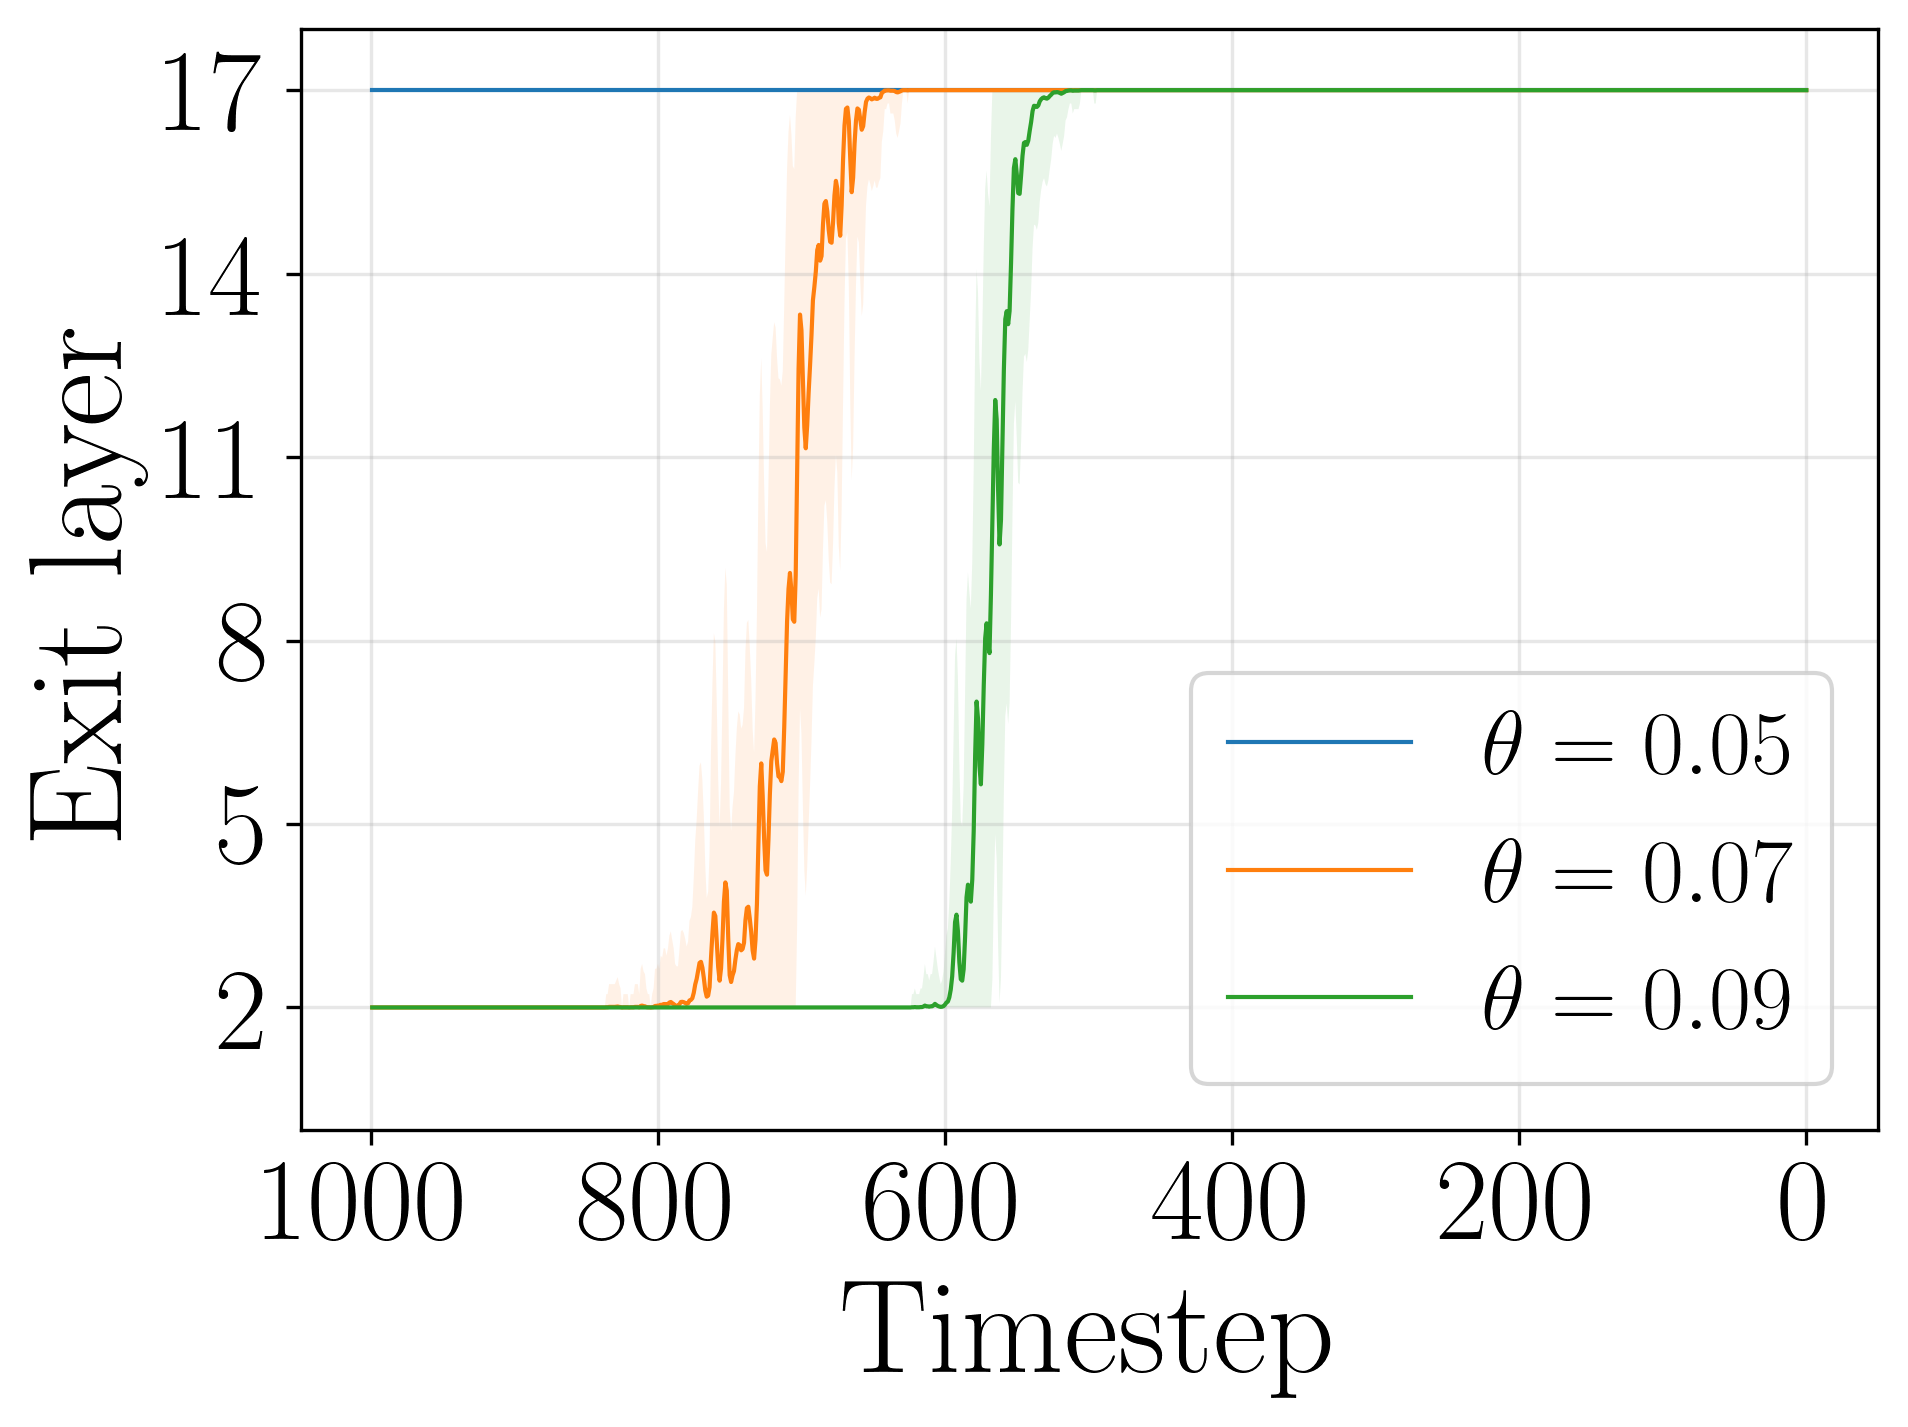

In [24]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(1000)

plt.ylabel("Exit layer", fontsize=32)
plt.xlabel("Timestep", fontsize=32)

for threshold, figures in figures_by_threshold.items():
    plt.plot(x, figures["y"], label=rf"$\theta = {threshold}$")
    plt.fill_between(x, figures["y_lower"], figures["y_upper"], alpha=0.1)

xticks = list(reversed(list(range(0, 1001, 200))))
plt.yticks(np.arange(2, 18, 3), np.arange(2, 18, 3), fontsize=28)
plt.gca().set_ylim([0,18])
plt.xticks(xticks, fontsize=28)
plt.gca().invert_xaxis()
# plt.title("Early exit trends for ImageNet256")
plt.legend(fontsize=22)
plt.tight_layout()
plt.savefig(f"../img/{dataset}_threshold.pdf")